In [ ]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Step 1: Unzip the folder
zip_file_path = '/content/final_apt_training.zip'  # Path to your uploaded zip file
extract_to_path = '/content/final_apt_training'  # Extraction destination

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

# Step 2: Locate the CSV file
extracted_files = os.listdir(extract_to_path)
csv_file_path = [os.path.join(extract_to_path, f) for f in extracted_files if f.endswith('.csv')][0]
print("CSV file found at:", csv_file_path)

# Step 3: Load the dataset
data = pd.read_csv(csv_file_path)
print("Dataset loaded successfully!")
print(data.info())

CSV file found at: /content/final_apt_training/final_apt_training.csv
Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259120 entries, 0 to 259119
Data columns (total 84 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow ID                     259119 non-null  object 
 1   Src IP                      259120 non-null  object 
 2   Src Port                    259120 non-null  int64  
 3   Dst IP                      259120 non-null  object 
 4   Dst Port                    259120 non-null  int64  
 5   Protocol                    259120 non-null  int64  
 6   Timestamp                   259120 non-null  object 
 7   Flow Duration               259120 non-null  int64  
 8   Total Fwd Packet            259120 non-null  int64  
 9   Total Bwd packets           259120 non-null  int64  
 10  Total Length of Fwd Packet  259120 non-null  float64
 11  Total Length of Bwd Packet  259

In [ ]:
# Step 4: Handle Missing Values
# Separate numeric and non-numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values in numeric columns with the median
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Fill missing values in non-numeric columns with a placeholder or mode
data[non_numeric_columns] = data[non_numeric_columns].fillna("Unknown")  # or use data[non_numeric_columns].mode().iloc[0]

# Verify if all missing values are handled
print("Missing values after handling:")
print(data.isnull().sum())


# Step 5: Encode Categorical Variables
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

# Retrieve mapping of labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Label Mapping (Original Category -> Encoded Value):")
print(label_mapping)

# Reverse mapping (Encoded Value -> Original Category)
reverse_mapping = {v: k for k, v in label_mapping.items()}
print("\nReverse Mapping (Encoded Value -> Original Category):")
print(reverse_mapping)

# Step 6: Normalize Continuous Features

# Step 1: Identify Columns with Inf or NaN
features_to_normalize = data.select_dtypes(include=['float64', 'int64']).columns

print("Checking for infinity and NaN values...")
print("Is infinity present?")
print(data[features_to_normalize].isin([float('inf'), float('-inf')]).sum())

print("\nIs NaN present?")
print(data[features_to_normalize].isnull().sum())

# Step 2: Replace Inf and NaN Values
# Replace inf and -inf with NaN
data[features_to_normalize] = data[features_to_normalize].replace([float('inf'), float('-inf')], pd.NA)

# Fill NaN values with the column median (safe choice for numerical features)
data[features_to_normalize] = data[features_to_normalize].fillna(data[features_to_normalize].median())

# Step 3: Verify no Inf or NaN values remain
print("\nAfter cleaning, check again:")
print("Is infinity present?")
print(data[features_to_normalize].isin([float('inf'), float('-inf')]).sum())
print("\nIs NaN present?")
print(data[features_to_normalize].isnull().sum())

# Step 4: Normalize with MinMaxScaler
scaler = MinMaxScaler()
data[features_to_normalize] = scaler.fit_transform(data[features_to_normalize])

print("Normalization complete!")

# Step 7: Balance the Dataset Using SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Step 1: Exclude Non-Numeric Columns from Features (X)
non_feature_columns = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']  # Adjust as needed
numeric_features = data.drop(columns=non_feature_columns, errors='ignore').select_dtypes(include=['float64', 'int64']).columns

# Prepare X and y for SMOTE
X = data[numeric_features]
y = data['Label']

# Ensure the target labels are encoded if they are not numeric
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("SMOTE applied successfully!")
print("Original dataset size:", X.shape)
print("Balanced dataset size:", X_balanced.shape)


# Step 8: Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Verify class distributions
train_distribution = pd.Series(y_train).value_counts(normalize=True)
test_distribution = pd.Series(y_test).value_counts(normalize=True)

print("Train class distribution:\n", train_distribution)
print("Test class distribution:\n", test_distribution)

Missing values after handling:
Flow ID      0
Src IP       0
Src Port     0
Dst IP       0
Dst Port     0
            ..
Idle Mean    0
Idle Std     0
Idle Max     0
Idle Min     0
Label        0
Length: 84, dtype: int64
Label Mapping (Original Category -> Encoded Value):
{'DataExfiltration': 0, 'InitialCompromise': 1, 'LateralMovement': 2, 'NormalTraffic': 3, 'Pivoting': 4, 'Reconnaissance': 5}

Reverse Mapping (Encoded Value -> Original Category):
{0: 'DataExfiltration', 1: 'InitialCompromise', 2: 'LateralMovement', 3: 'NormalTraffic', 4: 'Pivoting', 5: 'Reconnaissance'}
Checking for infinity and NaN values...
Is infinity present?
Src Port            0
Dst Port            0
Protocol            0
Flow Duration       0
Total Fwd Packet    0
                   ..
Idle Mean           0
Idle Std            0
Idle Max            0
Idle Min            0
Label               0
Length: 80, dtype: int64

Is NaN present?
Src Port            0
Dst Port            0
Protocol            0
Flow Dura

<ipython-input-2-5289d2a320a4>:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[features_to_normalize] = data[features_to_normalize].fillna(data[features_to_normalize].median())



After cleaning, check again:
Is infinity present?
Src Port            0
Dst Port            0
Protocol            0
Flow Duration       0
Total Fwd Packet    0
                   ..
Idle Mean           0
Idle Std            0
Idle Max            0
Idle Min            0
Label               0
Length: 80, dtype: int64

Is NaN present?
Src Port            0
Dst Port            0
Protocol            0
Flow Duration       0
Total Fwd Packet    0
                   ..
Idle Mean           0
Idle Std            0
Idle Max            0
Idle Min            0
Label               0
Length: 80, dtype: int64
Normalization complete!
SMOTE applied successfully!
Original dataset size: (259120, 79)
Balanced dataset size: (1529016, 79)
Train class distribution:
 2    0.166667
5    0.166667
0    0.166667
1    0.166667
4    0.166666
3    0.166666
Name: proportion, dtype: float64
Test class distribution:
 4    0.166669
3    0.166669
2    0.166666
1    0.166666
0    0.166666
5    0.166666
Name: proportion, d

In [ ]:
import pandas as pd

# Combine the balanced dataset
balanced_data = pd.DataFrame(X_balanced, columns=numeric_features)
balanced_data['Label'] = y_balanced  # Add the labels to the dataset

# Save the balanced dataset to a CSV file
balanced_csv_path = '/content/balanced_dataset.csv'
balanced_data.to_csv(balanced_csv_path, index=False)
print(f"Balanced dataset saved to {balanced_csv_path}")

Balanced dataset saved to /content/balanced_dataset.csv


In [ ]:
balanced_data=pd.read_csv('/content/balanced_dataset.csv')

In [ ]:
balanced_data['Label'].value_counts()

,count
Label,
3,254836
2,254836
5,254836
0,254836
4,254836
1,254836


Dataset preview:
   Src Port  Dst Port  Protocol  Flow Duration  Total Fwd Packet  \
0  0.752743  0.005949  0.352941       0.027678          0.007413   
1  0.752758  0.005949  0.352941       0.027509          0.005930   
2  0.000000  0.000000  0.000000       0.352142          0.001483   
3  0.000000  0.000000  0.000000       0.352283          0.001483   
4  0.002090  0.002095  1.000000       0.470805          0.002224   

   Total Bwd packets  Total Length of Fwd Packet  Total Length of Bwd Packet  \
0           0.013968                    0.001919                    0.001000   
1           0.003055                    0.002101                    0.000132   
2           0.000000                    0.000000                    0.000000   
3           0.000000                    0.000000                    0.000000   
4           0.000000                    0.001549                    0.000000   

   Fwd Packet Length Max  Fwd Packet Length Min  ...  Fwd Seg Size Min  \
0               0.0

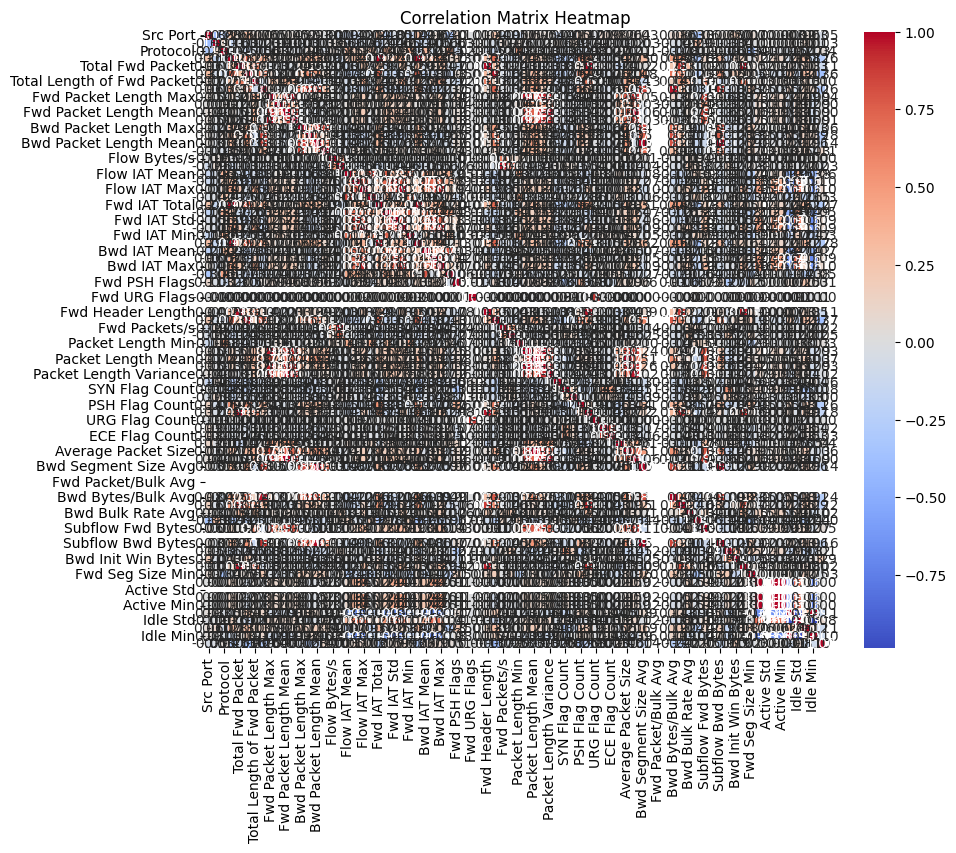

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataset.csv' with your actual file)
# Example: df = pd.read_csv("your_dataset.csv")
df = balanced_data

# Display the first few rows of the dataset
print("Dataset preview:")
print(df.head())

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Set threshold for high correlation
threshold = 0.9

# Find pairs of correlated features
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Highly correlated features to drop: {correlated_features}")

Highly correlated features to drop: {'Bwd Segment Size Avg', 'Idle Std', 'Bwd IAT Total', 'Bwd IAT Max', 'ACK Flag Count', 'Fwd IAT Total', 'Fwd Packet Length Mean', 'Average Packet Size', 'Fwd Packet Length Std', 'Bwd Bytes/Bulk Avg', 'Packet Length Variance', 'Fwd Packets/s', 'Subflow Bwd Bytes', 'Fwd Segment Size Avg', 'Fwd IAT Max', 'Packet Length Std', 'Fwd Act Data Pkts', 'Packet Length Max', 'Bwd Header Length', 'Idle Min', 'Bwd Packet/Bulk Avg', 'Fwd Header Length', 'Active Max', 'Active Min'}


In [ ]:
df = df.drop(columns=correlated_features)

In [ ]:
import xgboost
print(xgboost.__version__)

2.1.4


In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load a sample dataset (You can replace it with your dataset)
data = df
# Get feature names directly from columns (excluding the target column)
feature_names = data.columns[data.columns != 'Label']  # Assuming 'Label' is your target column
X = pd.DataFrame(data=data, columns=feature_names)
y = data['Label'] # Assuming 'Label' is your target column

# Feature scaling (optional, but generally improves model performance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset using the data after feature selection
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize the XGBoost model with GPU support
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # Use GPU accelerated histogram-based method
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Train the model using data after feature selection
model.fit(X_train, y_train)

# Get feature importances from the model
feature_importances = model.feature_importances_

# Set an importance threshold to select features
importance_threshold = 0.02  # Features with importance higher than 0.02 will be kept
important_features = np.where(feature_importances > importance_threshold)[0]

# Display the selected features
print("Selected Features based on importance threshold:")
selected_features = X.columns[important_features] # Use original X's columns
print(selected_features)

# Create the reduced dataset with selected features
X_selected = X.iloc[:, important_features] # Use X, not X_balanced

# Apply feature selection to training and testing sets
X_train_selected = X_train.iloc[:, important_features]
X_test_selected = X_test.iloc[:, important_features]

# You can now use X_selected for further modeling, validation, etc.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:46:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Selected Features based on importance threshold:
Index(['Src Port', 'Dst Port', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Bwd Packet Length Mean',
       'Packet Length Mean', 'PSH Flag Count', 'Bwd Bulk Rate Avg',
       'Subflow Fwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes',
       'Fwd Seg Size Min', 'Idle Mean', 'Idle Max'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:46:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
# import xgboost as xgb
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Load a sample dataset (You can replace it with your dataset)
# data = df
# # Get feature names directly from columns (excluding the target column)
# feature_names = data.columns[data.columns != 'Label']  # Assuming 'Label' is your target column
# X = pd.DataFrame(data=data, columns=feature_names)
# y = data['Label'] # Assuming 'Label' is your target column

# # Feature scaling (optional, but generally improves model performance)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(
#     X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
# )

# # Initialize the XGBoost model with GPU support
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     tree_method='gpu_hist',  # Use GPU accelerated histogram-based method
#     n_estimators=100,
#     max_depth=6,
#     learning_rate=0.1,
#     random_state=42
# )

# # Train the model
# model.fit(X_train, y_train)

# # Get feature importances from the model
# feature_importances = model.feature_importances_

# # Set an importance threshold to select features
# importance_threshold = 0.02  # Features with importance higher than 0.02 will be kept
# important_features = np.where(feature_importances > importance_threshold)[0]

# # Display the selected features
# print("Selected Features based on importance threshold:")
# selected_features = X.columns[important_features] # Use original X's columns
# print(selected_features)

# # Create the reduced dataset with selected features
# X_selected = X_balanced.iloc[:, important_features]

# # Apply feature selection to training and testing sets
# X_train_selected = X_train.iloc[:, important_features]
# X_test_selected = X_test.iloc[:, important_features]

# # You can now use X_selected for further modeling, validation, etc.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:07:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Selected Features based on importance threshold:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:07:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


IndexError: index 60 is out of bounds for axis 0 with size 55

In [ ]:
# Convert the final selected dataset to a DataFrame
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
X_selected_df['Label'] = y_balanced

# Save it as a CSV file
file_path = '/content/selected_features_dataset.csv'
X_selected_df.to_csv(file_path, index=False)

# # Provide a download link
# from google.colab import files
# files.download(file_path)

In [ ]:
print(X_selected_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1529016 entries, 0 to 1529015
Data columns (total 15 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Src Port                    1529016 non-null  float64
 1   Dst Port                    1529016 non-null  float64
 2   Total Bwd packets           1529016 non-null  float64
 3   Total Length of Fwd Packet  1529016 non-null  float64
 4   Bwd Packet Length Mean      1529016 non-null  float64
 5   Packet Length Mean          1529016 non-null  float64
 6   PSH Flag Count              1529016 non-null  float64
 7   Bwd Bulk Rate Avg           1529016 non-null  float64
 8   Subflow Fwd Bytes           1529016 non-null  float64
 9   FWD Init Win Bytes          1529016 non-null  float64
 10  Bwd Init Win Bytes          1529016 non-null  float64
 11  Fwd Seg Size Min            1529016 non-null  float64
 12  Idle Mean                   1529016 non-null  float64
 1

Models and Algorithms Implementation

In [ ]:
#================================================================================================================

In [ ]:
DT

In [ ]:
!pip install cupy-cuda11x cuml

  Using cached cupy_cuda11x-13.3.0-cp311-cp311-manylinux2014_x86_64.whl.metadata (2.7 kB)
  Using cached cuml-0.6.1.post1.tar.gz (1.1 kB)
  Preparing metadata (setup.py) ... done
Using cached cupy_cuda11x-13.3.0-cp311-cp311-manylinux2014_x86_64.whl (97.2 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cuml
  Running setup.py clean for cuml
Failed to build cuml
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (cuml)


In [ ]:
from cuml.tree import DecisionTreeClassifier  # GPU-accelerated Decision Tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss, roc_auc_score, classification_report, roc_curve, auc
import time
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already prepared.

# Step 1: Initialize GPU-Accelerated Decision Tree
dt_model = DecisionTreeClassifier(
    criterion='gini',  # or 'entropy'
    max_depth=6,  # Reduce depth to prevent overfitting
    min_samples_split=10,  # Minimum samples required to split a node
    min_samples_leaf=5,  # Minimum samples per leaf
    max_features='sqrt',  # Consider sqrt(features) at each split
    random_state=42
)

# Step 2: Train the model
start_time = time.time()
dt_model.fit(X_train, y_train)
training_time = time.time() - start_time  # Calculate training time

# Step 3: Make Predictions and measure inference time
start_inference_time = time.time()
y_pred = dt_model.predict(X_test)

# Get predicted probabilities for all classes (needed for log loss & AUC)
y_pred_prob = dt_model.predict_proba(X_test)
inference_time = time.time() - start_inference_time  # Calculate inference time

# Step 4: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_prob, labels=np.unique(y_test))

# ROC-AUC Score
if len(np.unique(y_test)) == 2:  # Binary classification
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
    auc_value = auc(fpr, tpr)
elif len(np.unique(y_test)) > 2:  # Multi-class classification
    auc_value = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

class_report = classification_report(y_test, y_pred)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Log Loss: {log_loss_value:.4f}")
print(f"AUC: {auc_value:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Output Training and Inference Times
print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")

ModuleNotFoundError: No module named 'cuml'

Random Forest on training data

In [ ]:
X_train = X_train_selected
X_test = X_test_selected

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
import time
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already prepared.

# Step 1: Convert the dataset to DMatrix, which is the internal data structure of XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 2: Set up the parameters for the XGBoost model with regularization
params = {
    'objective': 'multi:softmax',  # For multi-class classification
    'num_class': len(np.unique(y_train)),  # Number of classes in the target variable
    'tree_method': 'hist',  # Use histogram-based algorithm for faster training on GPU
    'device': 'cuda',  # Use GPU (CUDA) for training
    'max_depth': 6,  # Reduce the maximum depth of the trees to prevent overfitting
    'min_child_weight': 10,  # Higher value to ensure sufficient samples in leaves
    'colsample_bytree': 0.7,  # Fraction of features used for building each tree
    'subsample': 0.7,  # Fraction of samples used for training each tree
    'learning_rate': 0.05,  # Lower learning rate to prevent overfitting
    'n_estimators': 100,  # Reduce the number of trees
    'eval_metric': 'mlogloss',  # Evaluation metric (log loss)
    'gamma': 1,  # Higher gamma value to control splitting
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5  # L1 regularization term
}

# Step 3: Train the model
start_time = time.time()
bst = xgb.train(params, dtrain, num_boost_round=100, early_stopping_rounds=10, evals=[(dtest, 'test')])  # Early stopping rounds to prevent overfitting

training_time = time.time() - start_time  # Calculate training time

# Step 4: Make Predictions and measure inference time
start_inference_time = time.time()

y_pred = bst.predict(dtest)
# Get predicted probabilities for all classes
y_pred_prob = bst.predict(dtest, output_margin=True)  # Get raw margin scores

# Convert margin scores to probabilities using softmax
y_pred_prob = np.exp(y_pred_prob) / np.sum(np.exp(y_pred_prob), axis=1, keepdims=True)

inference_time = time.time() - start_inference_time  # Calculate inference time



# Step 5: Evaluate the Model

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred, average='weighted')

# Recall
recall = recall_score(y_test, y_pred, average='weighted')

# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Log Loss
log_loss_value = log_loss(y_test, y_pred_prob, labels=np.unique(y_test))

# ROC-AUC Curve (assuming binary classification or multi-class, adjust as necessary)
if len(np.unique(y_test)) == 2:  # Binary classification
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])  # Get probability for class 1
    auc_value = auc(fpr, tpr)
elif len(np.unique(y_test)) > 2:  # Multi-class classification
    auc_value = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')

# Classification report
class_report = classification_report(y_test, y_pred)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Log Loss: {log_loss_value:.4f}")
print(f"AUC: {auc_value:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Output Training and Inference Times
print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	test-mlogloss:1.67417
[1]	test-mlogloss:1.56788
[2]	test-mlogloss:1.47683
[3]	test-mlogloss:1.39152
[4]	test-mlogloss:1.31149
[5]	test-mlogloss:1.23926
[6]	test-mlogloss:1.17455
[7]	test-mlogloss:1.11485
[8]	test-mlogloss:1.06125
[9]	test-mlogloss:1.00987
[10]	test-mlogloss:0.96280
[11]	test-mlogloss:0.91925
[12]	test-mlogloss:0.87643
[13]	test-mlogloss:0.83814
[14]	test-mlogloss:0.80172
[15]	test-mlogloss:0.76768
[16]	test-mlogloss:0.73494
[17]	test-mlogloss:0.70481
[18]	test-mlogloss:0.67597
[19]	test-mlogloss:0.64870
[20]	test-mlogloss:0.62311
[21]	test-mlogloss:0.59850
[22]	test-mlogloss:0.57433
[23]	test-mlogloss:0.55132
[24]	test-mlogloss:0.53024
[25]	test-mlogloss:0.50975
[26]	test-mlogloss:0.49120
[27]	test-mlogloss:0.47427
[28]	test-mlogloss:0.45703
[29]	test-mlogloss:0.44090
[30]	test-mlogloss:0.42504
[31]	test-mlogloss:0.41006
[32]	test-mlogloss:0.39580
[33]	test-mlogloss:0.38278
[34]	test-mlogloss:0.36955
[35]	test-mlogloss:0.35731
[36]	test-mlogloss:0.34545
[37]	test-m

Testing data


In [ ]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Step 1: Unzip the folder
zip_file_path = '/content/final_apt_testing.zip'  # Path to your uploaded zip file
extract_to_path = '/content/final_apt_testing'  # Extraction destination

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

# Step 2: Locate the CSV file
extracted_files = os.listdir(extract_to_path)
csv_file_path = [os.path.join(extract_to_path, f) for f in extracted_files if f.endswith('.csv')][0]
print("CSV file found at:", csv_file_path)

# Step 3: Load the dataset
data1 = pd.read_csv(csv_file_path)
print("Dataset loaded successfully!")
print(data1.info()) # Check basic information about the dataset

CSV file found at: /content/final_apt_testing/final_apt_testing.csv
Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56487 entries, 0 to 56486
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Flow ID                     56487 non-null  object 
 1   Src IP                      56487 non-null  object 
 2   Src Port                    56487 non-null  int64  
 3   Dst IP                      56487 non-null  object 
 4   Dst Port                    56487 non-null  int64  
 5   Protocol                    56487 non-null  int64  
 6   Timestamp                   56487 non-null  object 
 7   Flow Duration               56487 non-null  int64  
 8   Total Fwd Packet            56487 non-null  int64  
 9   Total Bwd packets           56487 non-null  int64  
 10  Total Length of Fwd Packet  56487 non-null  int64  
 11  Total Length of Bwd Packet  56487 non-null  int6

Testing data pp

In [ ]:
data1.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.88.61-192.168.88.1-949-53-17,192.168.88.61,949,192.168.88.1,53,17,10/20/2015 11:10,4003324,3,3,...,8,0,0,0,0,1.450000e+15,0.000000e+00,1.450000e+15,1.450000e+15,NormalTraffic
1,192.168.88.61-192.168.88.1-949-53-17,192.168.88.61,949,192.168.88.1,53,17,10/20/2015 11:10,4003177,3,3,...,8,0,0,0,0,1.450000e+15,0.000000e+00,1.450000e+15,1.450000e+15,NormalTraffic
2,192.168.88.61-192.168.88.1-949-53-17,192.168.88.61,949,192.168.88.1,53,17,10/20/2015 11:10,4055352,3,3,...,8,0,0,0,0,1.450000e+15,0.000000e+00,1.450000e+15,1.450000e+15,NormalTraffic
3,192.168.89.2-8.8.8.8-2056-53-17,192.168.89.2,2056,8.8.8.8,53,17,10/20/2015 11:10,4999650,2,0,...,8,0,0,0,0,7.230000e+14,1.020000e+15,1.450000e+15,4.999650e+06,NormalTraffic
4,192.168.89.1-192.168.89.2-2056-53-17,192.168.89.1,2056,192.168.89.2,53,17,10/20/2015 11:10,4999640,2,0,...,8,0,0,0,0,7.230000e+14,1.020000e+15,1.450000e+15,4.999640e+06,NormalTraffic


In [ ]:
data1.shape

(56487, 84)

In [ ]:
print("Unique labels in testing data before encoding:", data1['Label'].unique())

Unique labels in testing data before encoding: ['NormalTraffic' 'InitialCompromise' 'Reconnaissance' 'Pivoting'
 'LateralMovement' 'DataExfiltration']


In [ ]:
# Assuming 'testing_data' is your testing dataset (replace it with the actual variable name)
testing_data = data1

# Step 4: Handle Missing Values
# Separate numeric and non-numeric columns
numeric_columns = testing_data.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = testing_data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values in numeric columns with the median
testing_data[numeric_columns] = testing_data[numeric_columns].fillna(testing_data[numeric_columns].median())

# Fill missing values in non-numeric columns with a placeholder or mode
testing_data[non_numeric_columns] = testing_data[non_numeric_columns].fillna("Unknown")  # or use testing_data[non_numeric_columns].mode().iloc[0]

# Verify if all missing values are handled
print("Missing values after handling in testing data:")
print(testing_data.isnull().sum())

# Step 5: Encode Categorical Variables (Use the same label encoder from training)

# Your provided label mapping
label_mapping = {
    'DataExfiltration' : 0,
    'InitialCompromise' : 1,
    'LateralMovement' : 2,
    'NormalTraffic' : 3,
    'Pivoting' : 4,
    'Reconnaissance':5
}

# Apply the label mapping to the testing dataset
# Ensure all labels are properly mapped
testing_data['Label'] = testing_data['Label'].map(label_mapping).fillna(-1)  # Assign -1 to unknown labels

# Convert to integer type (optional but useful)
testing_data['Label'] = testing_data['Label'].astype(int)

# Check if there are still NaN values
print("Unique labels in testing data after encoding:", testing_data['Label'].unique())


# Verify if the mapping was applied correctly
print(testing_data['Label'].unique())

#Apply the same transformation as in the training data

# Step 6: Normalize Continuous Features (Using the same scaler from training)
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Now transform the testing data using the already fitted scaler
X_test_scaled = scaler.transform(X_test)

# Proceed with your model training and evaluation
# Use the scaler fitted on training data

print("Testing data normalization complete!")

# Step 7: Prepare Testing Data for Model Evaluation
# Exclude non-feature columns (similar to training data preprocessing)
non_feature_columns = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']  # Adjust as needed
numeric_features = testing_data.drop(columns=non_feature_columns, errors='ignore').select_dtypes(include=['float64', 'int64']).columns

X_testing = testing_data[numeric_features]
y_testing = testing_data['Label']

# Now, X_test and y_test are ready for evaluation

Missing values after handling in testing data:
Flow ID      0
Src IP       0
Src Port     0
Dst IP       0
Dst Port     0
            ..
Idle Mean    0
Idle Std     0
Idle Max     0
Idle Min     0
Label        0
Length: 84, dtype: int64
Unique labels in testing data after encoding: [3 1 5 4 2 0]
[3 1 5 4 2 0]
Testing data normalization complete!


In [ ]:
testing_data.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.88.61-192.168.88.1-949-53-17,192.168.88.61,949,192.168.88.1,53,17,10/20/2015 11:10,4003324,3,3,...,8,0,0,0,0,1.450000e+15,0.000000e+00,1.450000e+15,1.450000e+15,3
1,192.168.88.61-192.168.88.1-949-53-17,192.168.88.61,949,192.168.88.1,53,17,10/20/2015 11:10,4003177,3,3,...,8,0,0,0,0,1.450000e+15,0.000000e+00,1.450000e+15,1.450000e+15,3
2,192.168.88.61-192.168.88.1-949-53-17,192.168.88.61,949,192.168.88.1,53,17,10/20/2015 11:10,4055352,3,3,...,8,0,0,0,0,1.450000e+15,0.000000e+00,1.450000e+15,1.450000e+15,3
3,192.168.89.2-8.8.8.8-2056-53-17,192.168.89.2,2056,8.8.8.8,53,17,10/20/2015 11:10,4999650,2,0,...,8,0,0,0,0,7.230000e+14,1.020000e+15,1.450000e+15,4.999650e+06,3
4,192.168.89.1-192.168.89.2-2056-53-17,192.168.89.1,2056,192.168.89.2,53,17,10/20/2015 11:10,4999640,2,0,...,8,0,0,0,0,7.230000e+14,1.020000e+15,1.450000e+15,4.999640e+06,3


In [ ]:
y_testing.head()

,Label
0,3
1,3
2,3
3,3
4,3


In [ ]:
X_testing.shape

(56487, 79)

In [ ]:
# import numpy as np
# import pandas as pd

# # Ensure X_final_test is a DataFrame
# X_final_test = pd.DataFrame(X_final_test)

# # Check for NaN values
# print("NaN values in X_final_test:", X_final_test.isna().any().any())
# print("NaN values in y_final_test:", pd.isna(y_final_test).any())

# # Check for infinite values
# print("Infinite values in X_final_test:", np.isinf(X_final_test).any().any())

# # Replace NaN values with column mean
# X_final_test = X_final_test.fillna(X_final_test.mean())

# # Replace infinite values with column mean (directly)
# X_final_test.replace([np.inf, -np.inf], np.nan, inplace=True)
# X_final_test.fillna(X_final_test.mean(), inplace=True)

# # Convert y_final_test to a Pandas Series if it's not already
# y_final_test = pd.Series(y_final_test)

# # Create a mask for valid values in y_final_test (non-NaN)
# mask = ~y_final_test.isna()

# # Apply mask to filter out NaN rows
# X_final_test = X_final_test.loc[mask].reset_index(drop=True)
# y_final_test = y_final_test.loc[mask].reset_index(drop=True)

# # Check again for NaN or infinite values
# print("NaN values in X_final_test after processing:", X_final_test.isna().any().any())
# print("NaN values in y_final_test after processing:", y_final_test.isna().any())
# print("Infinite values in X_final_test after processing:", np.isinf(X_final_test).any().any())


NaN values in X_final_test: False
NaN values in y_final_test: False
Infinite values in X_final_test: False
NaN values in X_final_test after processing: False
NaN values in y_final_test after processing: False
Infinite values in X_final_test after processing: False


In [ ]:
X_testing.shape

(56487, 79)

In [ ]:
X_final_test = X_testing
y_final_test= y_testing

In [ ]:
print("NaN values in X_final_test:", X_final_test.isna().any().any())
print("NaN values in y_final_test:", pd.isna(y_final_test).any())

# Check for infinite values
print("Infinite values in X_final_test:", np.isinf(X_final_test).any().any())

NaN values in X_final_test: False
NaN values in y_final_test: False
Infinite values in X_final_test: True


In [ ]:
print(f"X_final_test shape: {X_final_test.shape}")
print(f"y_final_test shape: {y_final_test.shape}")

X_final_test shape: (56487, 79)
y_final_test shape: (56487,)


In [ ]:
y_final_test.head()

,Label
0,3
1,3
2,3
3,3
4,3


In [ ]:
X= X_final_test
y = y_final_test
print("Total NaN values in y:", y.isna().sum())
print("y unique values:", y.unique()[:10])

Total NaN values in y: 0
y unique values: [3 1 5 4 2 0]


In [ ]:
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values (originally inf) with column mean
X.fillna(X.mean(), inplace=True)

# Verify no inf or NaN values remain
print("NaN values in X:", X.isna().sum().sum())
print("Infinite values in X:", np.isinf(X).sum().sum())

NaN values in X: 0
Infinite values in X: 0


<ipython-input-55-b263fe156044>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-55-b263fe156044>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [ ]:
X_final_test = X
y_final_test = y

In [ ]:
print("NaN values in X_final_test:", X_final_test.isna().any().any())
print("NaN values in y_final_test:", pd.isna(y_final_test).any())

# Check for infinite values
print("Infinite values in X_final_test:", np.isinf(X_final_test).any().any())

NaN values in X_final_test: False
NaN values in y_final_test: False
Infinite values in X_final_test: False


In [ ]:
print(f"X_final_test shape: {X_final_test.shape}")
print(f"y_final_test shape: {y_final_test.shape}")

X_final_test shape: (56487, 79)
y_final_test shape: (56487,)


Testing of Random Forest on Testing Data

In [ ]:
X_final_test = pd.DataFrame(X_final_test)

# Get the feature names used during training
training_feature_names = bst.feature_names

# Select only the features used during training from the testing data
X_final_test_selected = X_final_test[[col for col in training_feature_names if col in X_final_test.columns]]

# Convert the final testing dataset to DMatrix, using the selected features
dfinal_test = xgb.DMatrix(X_final_test_selected, label=y_final_test)

# Measure inference time
start_inference_time = time.time()

# Make predictions
y_final_pred = bst.predict(dfinal_test)

# Get predicted probabilities for all classes
y_final_pred_prob = bst.predict(dfinal_test, output_margin=True)

# Convert margin scores to probabilities using softmax
if y_final_pred_prob.ndim == 1:  # Binary case
    y_final_pred_prob = 1 / (1 + np.exp(-y_final_pred_prob))  # Sigmoid
else:  # Multi-class case
    y_final_pred_prob = np.exp(y_final_pred_prob) / np.sum(np.exp(y_final_pred_prob), axis=1, keepdims=True)


final_inference_time = time.time() - start_inference_time  # Calculate inference time

# Evaluate the Model on Final Test Data

# Accuracy
final_accuracy = accuracy_score(y_final_test, y_final_pred)

# Precision
final_precision = precision_score(y_final_test, y_final_pred, average='weighted')

# Recall
final_recall = recall_score(y_final_test, y_final_pred, average='weighted')

# F1 Score
final_f1 = f1_score(y_final_test, y_final_pred, average='weighted')

# Confusion Matrix
final_conf_matrix = confusion_matrix(y_final_test, y_final_pred)

# Log Loss
final_log_loss_value = log_loss(y_final_test, y_final_pred_prob, labels=np.unique(y_final_test))

# ROC-AUC Curve
if len(np.unique(y_final_test)) == 2:  # Binary classification
    fpr, tpr, thresholds = roc_curve(y_final_test, y_final_pred_prob[:, 1])
    final_auc_value = auc(fpr, tpr)
elif len(np.unique(y_final_test)) > 2:  # Multi-class classification
    final_auc_value = roc_auc_score(y_final_test, y_final_pred_prob, multi_class='ovr', average='weighted')

# Classification Report
final_class_report = classification_report(y_final_test, y_final_pred)

# Print Evaluation Metrics
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")
print(f"Final F1 Score: {final_f1:.4f}")
print(f"Final Log Loss: {final_log_loss_value:.4f}")
print(f"Final AUC: {final_auc_value:.4f}")

print("\nFinal Confusion Matrix:")
print(final_conf_matrix)
print("\nFinal Classification Report:")
print(final_class_report)

# Output Final Inference Time
print(f"Final Inference Time: {final_inference_time:.2f} seconds")

Final Accuracy: 0.9773
Final Precision: 0.9682
Final Recall: 0.9773
Final F1 Score: 0.9728
Final Log Loss: 0.3352
Final AUC: 0.6539

Final Confusion Matrix:
[[    0     0     0    74     0     0]
 [    0     0     0    74     3     0]
 [    0     0     0   142     0     0]
 [    0     0     0 55205   378     0]
 [    0     0     0   359     1     0]
 [    0     0     0   251     0     0]]

Final Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.00      0.00      0.00        77
           2       0.00      0.00      0.00       142
           3       0.98      0.99      0.99     55583
           4       0.00      0.00      0.00       360
           5       0.00      0.00      0.00       251

    accuracy                           0.98     56487
   macro avg       0.16      0.17      0.17     56487
weighted avg       0.97      0.98      0.97     56487

Final Inference Time: 0.03 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rf

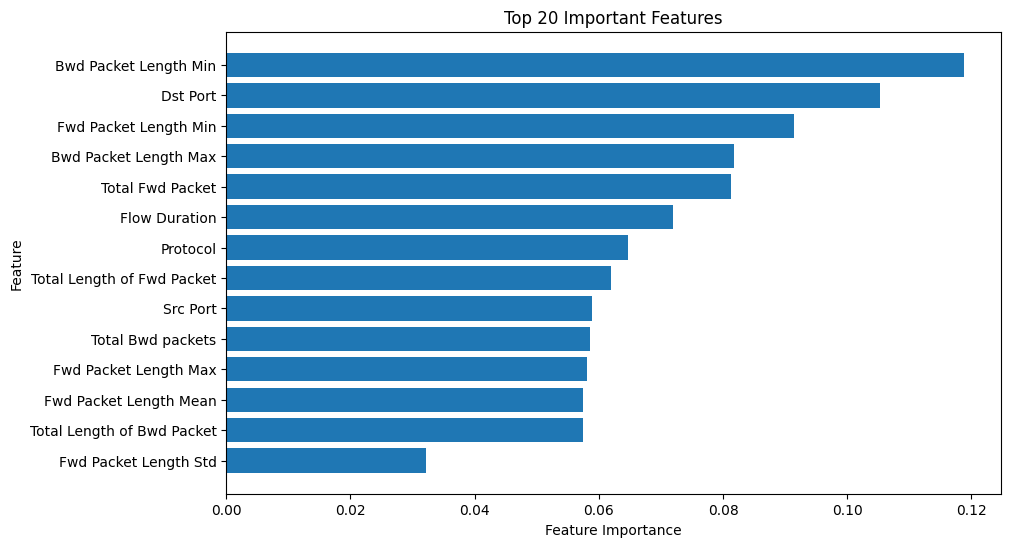

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as rf # Import the classifier

# Instantiate and fit the model (using your training data: X_train, y_train)
rf_model = rf(random_state=42)  # Create a RandomForestClassifier object
rf_model.fit(X_train, y_train)  # Train the model on your training data

# Get feature importances from the fitted model
importances = rf_model.feature_importances_
feature_names = X_balanced.columns

# Sort and plot top features
sorted_idx = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Important Features")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Remove the top 1-2 highly dominant features, but only if they exist in X_train
top_features = [feature for feature in [feature_names[i] for i in sorted_idx][:2] if feature in X_train.columns]

# If top_features is empty, skip filtering
if top_features:
    X_train_filtered = X_train.drop(columns=top_features)
    X_test_filtered = X_test.drop(columns=top_features)
else:
    X_train_filtered = X_train
    X_test_filtered = X_test

# Re-train the model
# Use rf_model instead of rf
rf_model.fit(X_train_filtered, y_train)  # Assuming 'rf_model' is your RandomForestClassifier object
y_pred = rf_model.predict(X_test_filtered)

# Evaluate performance again
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50967
           1       1.00      1.00      1.00     50967
           2       1.00      1.00      1.00     50967
           3       1.00      1.00      1.00     50968
           4       1.00      1.00      1.00     50968
           5       1.00      1.00      1.00     50967

    accuracy                           1.00    305804
   macro avg       1.00      1.00      1.00    305804
weighted avg       1.00      1.00      1.00    305804



In [ ]:
# Get the least important features (adjust threshold as needed)
low_importance_features = [feature_names[i] for i in sorted_idx if importances[i] < 0.005]

# Drop them from dataset
X_train_filtered = X_train.drop(columns=low_importance_features)
X_test_filtered = X_test.drop(columns=low_importance_features)

# Re-train model
rf.fit(X_train_filtered, y_train)
y_pred = rf.predict(X_test_filtered)

# Evaluate performance again
print(classification_report(y_test, y_pred))

In [ ]:

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Define Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=10, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
print("Best RF Params:", rf_model.best_params_)
rf_preds = rf_model.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, rf_preds))

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost Report:\n", classification_report(y_test, xgb_preds))

# Train SVM with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("SVM Report:\n", classification_report(y_test, svm_preds))
